In [1]:
from functools import partial
from pathlib import Path

from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from itertools import product
from rasterio.windows import Window
import rasterio
import numpy as np
import torchmetrics.functional as metrics
import torch

import dl_toolbox.datasets as datasets
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import dl_toolbox.utils as utils
from dl_toolbox.modules import Supervised
from dl_toolbox.networks import SmpUnet
from dl_toolbox.losses import DiceLoss
import dl_toolbox.callbacks as cb

#if os.uname().nodename == 'WDTIS890Z': 
#    data_root = Path('/mnt/d/pfournie/Documents/data')
#    home = Path('/home/pfournie')
#    save_root = data_root / 'outputs'
#elif os.uname().nodename == 'qdtis056z': 
#    data_root = Path('/data')
#    home = Path('/d/pfournie')
#    save_root = data_root / 'outputs'
#elif os.uname().nodename.endswith('sis.cnes.fr'):
#    home = Path('/home/eh/fournip')
#    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'
#    if test:
#        data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
#    else:
#        #!bash '/home/eh/fournip/dl_toolbox/copy_data_to_node.sh'
#        data_root = Path(os.environ['TMPDIR'])

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module = Supervised(
    network=partial(SmpUnet, encoder_name='efficientnet-b0'),
    optimizer=None,
    scheduler=None,
    ce_loss=partial(nn.CrossEntropyLoss),
    dice_loss=partial(DiceLoss),
    class_weights=[1]*10,
    ce_weight=0,
    dice_weight=0,
    in_channels=3,
    num_classes=10,
    tf=tf.NoOp(),
    tta=None
)

{'encoder_name': 'efficientnet-b0', 'in_channels': 3}


In [3]:
ckpt = '/data/outputs/digitanie_ai4geo/run_sup/2023-09-20_134642/checkpoints/epoch_100.ckpt'
base = Path('/data/DIGITANIE_v4')
imgp = base/'ARCACHON/ARCACHON_20180821_16bits_COG_0.tif'
with rasterio.open(imgp, "r") as file:
    img = file.read(out_dtype=np.float32, indexes=[1,2,3])
mskp = base/'ARCACHON/COS9/ARCACHON_0_mask.tif'
with rasterio.open(mskp, "r") as file:
    msk = file.read(out_dtype=np.uint8)
classes = datasets.Digitanie.classes['all9'].value


In [4]:
tiles = list(utils.get_tiles(2048, 2048, 512, step_w=256))
ds = datasets.Digitanie(
    [imgp]*len(tiles),
    [mskp]*len(tiles),
    tiles,
    [1,2,3],
    'all9',
    tf.NormalizeFromNpy(
        npy='/data/DIGITANIE_v4/normalisation_stats.npy',
        city='ARCACHON',
        min_p='2',
        max_p='995',
        bands=[1,2,3]
    )
)

loader = DataLoader(
    dataset=ds,
    collate_fn=utils.CustomCollate(),
    batch_size=8,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)


In [5]:
merge_preds = cb.MergePreds((2048,2048))
trainer = Trainer(
    accelerator="gpu",
    devices=1,
    limit_predict_batches=1.,
    callbacks=[merge_preds],
    logger=False
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..


In [11]:
trainer.predict(model=module, dataloaders=loader, ckpt_path=ckpt)
probas = module.logits2probas(merge_preds.merged.unsqueeze(dim=0))
confs, preds = module.probas2confpreds(probas)

Restoring states from the checkpoint path at /data/outputs/digitanie_ai4geo/run_sup/2023-09-20_134642/checkpoints/epoch_100.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/digitanie_ai4geo/run_sup/2023-09-20_134642/checkpoints/epoch_100.ckpt


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.40it/s]


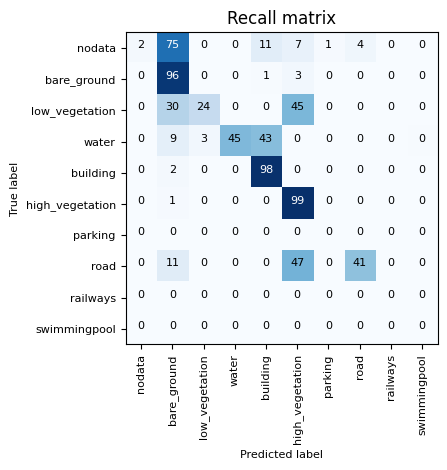

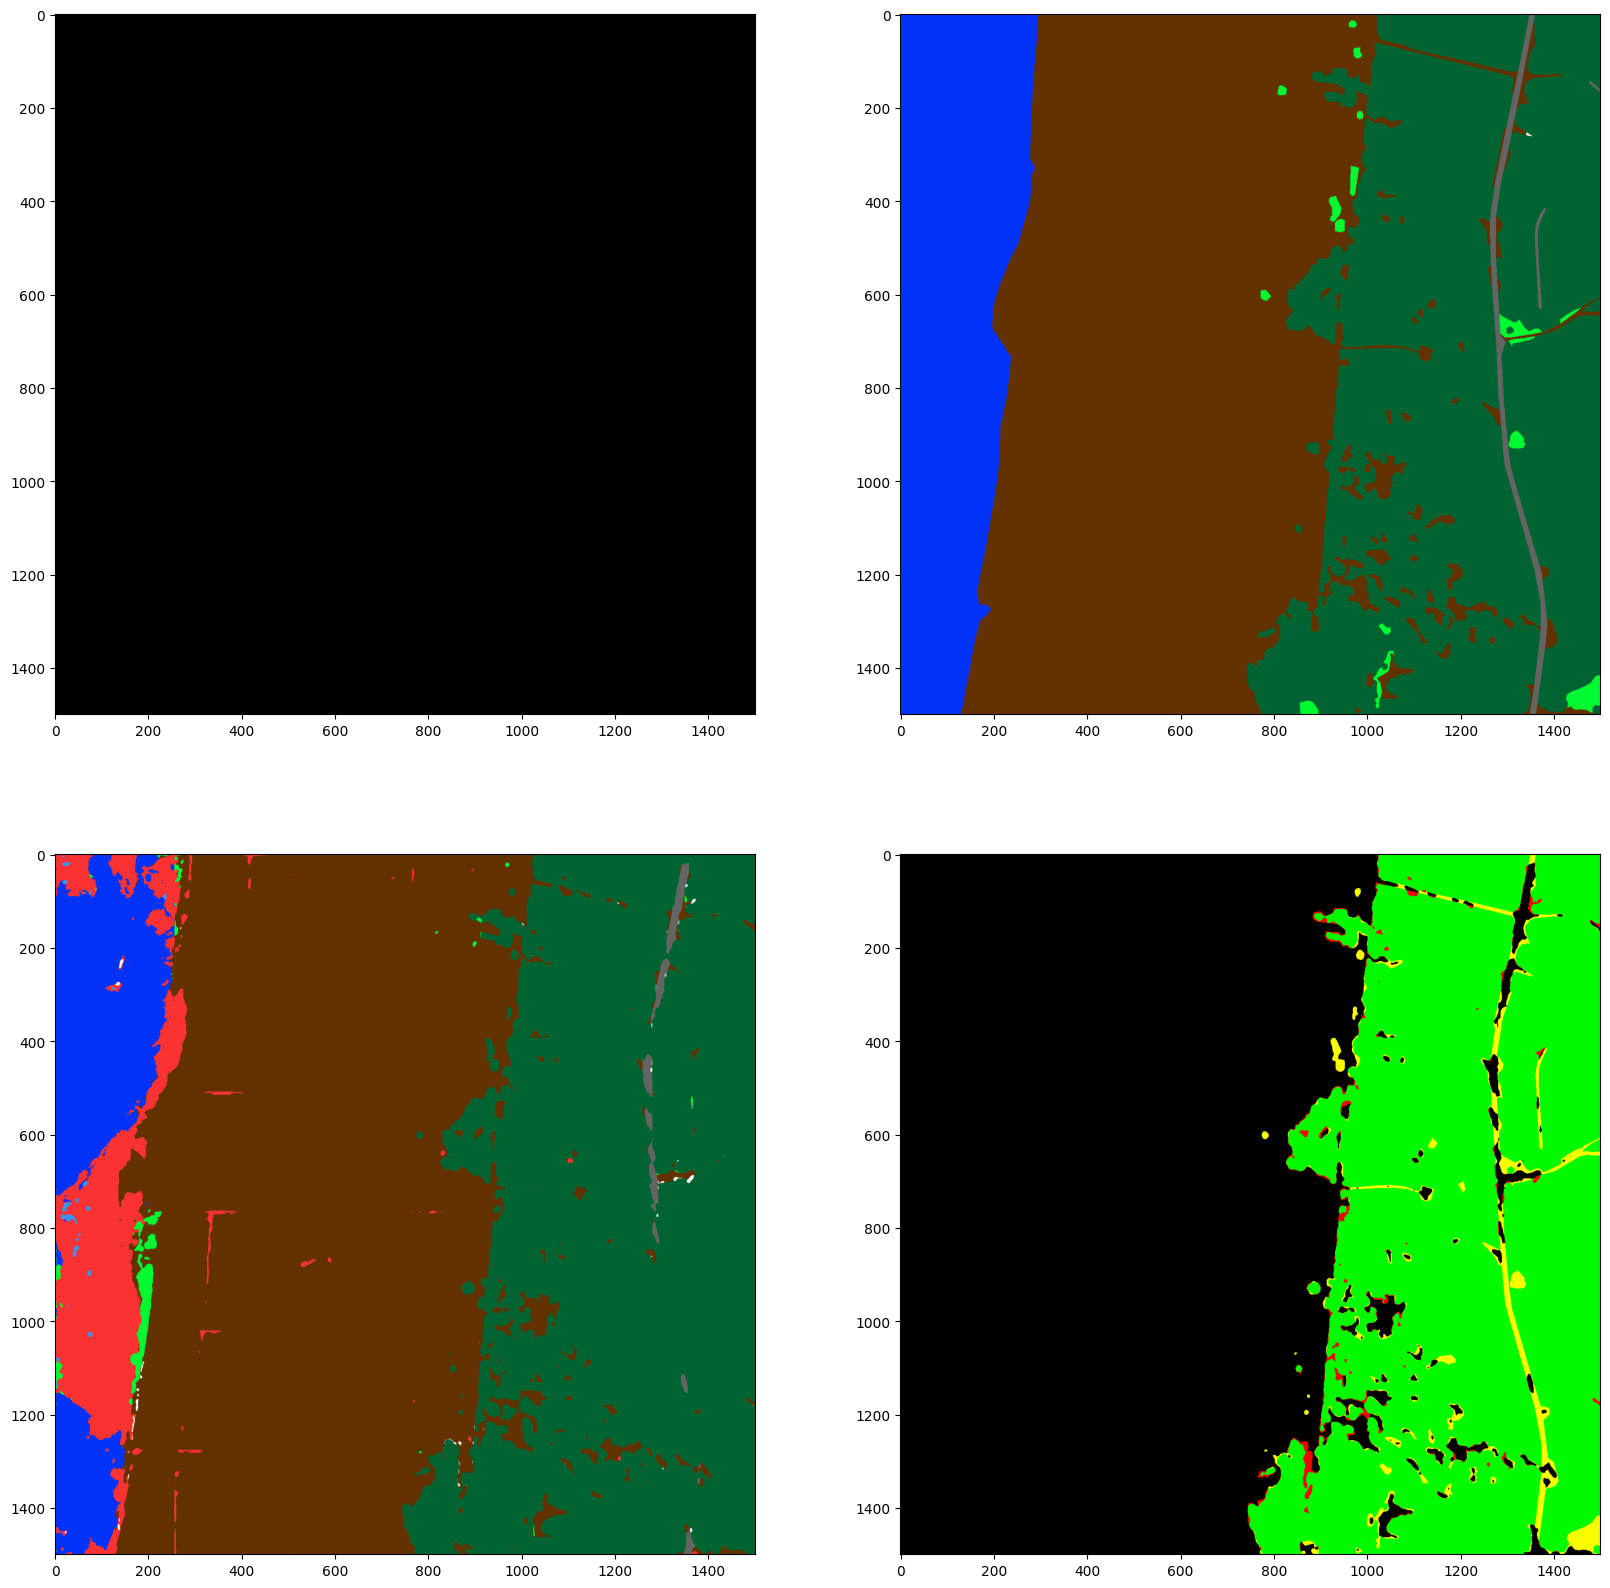

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

cm = metrics.classification.multiclass_confusion_matrix(preds, torch.Tensor(msk), num_classes=10)
names = [l.name for l in classes]
utils.plot_confusion_matrix(cm, names, "recall", fontsize=8)

preds_np = preds.squeeze().numpy()
msk_np = msk.squeeze()
img = tf.StretchToMinmax([0]*3, [3500,2900,2000])(torch.Tensor(img))[0].numpy()
overlay = np.zeros(shape=(*preds_np.shape, 3), dtype=np.uint8)
label_bool = msk_np == 5
pred_bool = preds_np == 5
colors = [(i, l.color) for i, l in enumerate(classes)]

# Correct predictions (Hits) painted with green
overlay[label_bool & pred_bool] = np.array([0, 250, 0], dtype=overlay.dtype)
# Misses painted with red
overlay[label_bool & ~pred_bool] = np.array([250, 0, 0], dtype=overlay.dtype)
# False alarm painted with yellow
overlay[~label_bool & pred_bool] = np.array([250, 250, 0], dtype=overlay.dtype)

zone = np.s_[0:1500, 0:1500,:3]

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax1.imshow(img.transpose(1,2,0)[zone])
ax2 = fig.add_subplot(222)
ax2.imshow(utils.labels_to_rgb(msk_np, colors)[zone])
ax3 = fig.add_subplot(223)
ax3.imshow(utils.labels_to_rgb(preds_np, colors)[zone])
ax4 = fig.add_subplot(224)
ax4.imshow(overlay[zone])